# Imports

In [1]:
import sys
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.stats import zscore
from scipy.signal import spectrogram
from scipy.signal import periodogram
from scipy.signal import iirnotch
from scipy.signal import find_peaks
from scipy.signal import welch
from voltage_imaging import *

# Parameters

In [30]:
threshold = 2
half_window = 25 #Samples
half_window_STA = 5

# Loading file

In [31]:
meta = loadMeta()
dict_data = dict()
for fname in meta['File'].unique():
    path = os.path.join('..', 'data', fname.split('_')[0], fname + '.mes')
    dict_data[fname] = loadmat(path, squeeze_me = True)

# Plotting all recordings

## Selecting recordings to display

In [32]:
# meta_plot = meta
meta_plot = meta.query('File == "20211129_beads_control"')
meta_plot

,Date,File,Measure_ID,Cage,Animal,State,Cell,Mode,Diameter,Wavelength,...,Start_cutoff,Samp_per_pix,Frate,FOV_edge,Objective,Airpuff,Notes,Indicator,Kymo_start,Kymo_end
73,2021/11/29,20211129_beads_control,1,NaN,NaN,beads,1.0,line,NaN,950.0,...,300,4,500.0,80,25x,NaN,NaN,NaN,NaN,NaN
74,2021/11/29,20211129_beads_control,2,NaN,NaN,beads,1.0,line,NaN,950.0,...,300,4,500.0,80,25x,NaN,NaN,NaN,NaN,NaN
75,2021/11/29,20211129_beads_control,3,NaN,NaN,beads,1.0,circle,10.0,950.0,...,300,4,500.0,80,25x,NaN,more on the edges,NaN,NaN,NaN
76,2021/11/29,20211129_beads_control,4,NaN,NaN,beads,1.0,circle,8.0,950.0,...,300,4,500.0,80,25x,NaN,more in the inner circle,NaN,NaN,NaN
77,2021/11/29,20211129_beads_control,5,NaN,NaN,beads,1.0,circle,8.0,NaN,...,300,4,500.0,80,25x,NaN,laser off,NaN,NaN,NaN
78,2021/11/29,20211129_beads_control,6,NaN,NaN,beads,NaN,circle,8.0,950.0,...,300,4,500.0,80,25x,NaN,"laser on, background",NaN,NaN,NaN


## Plotting traces

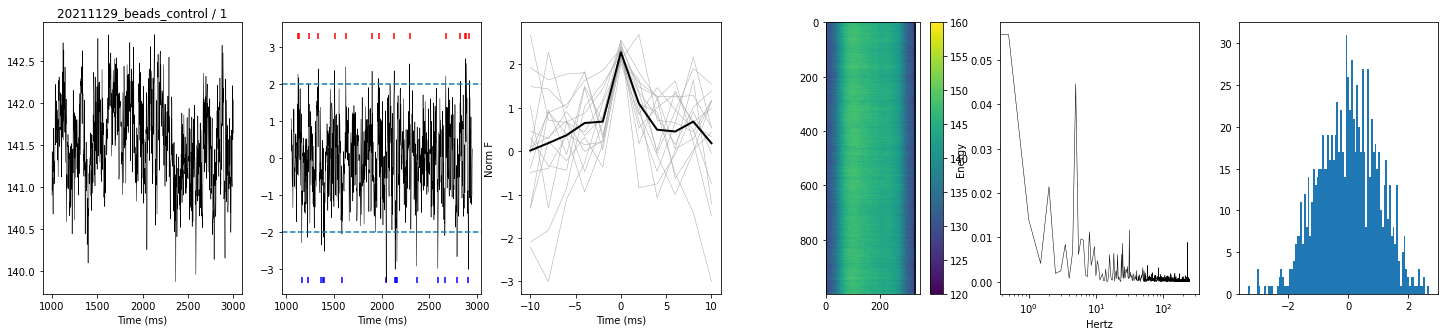

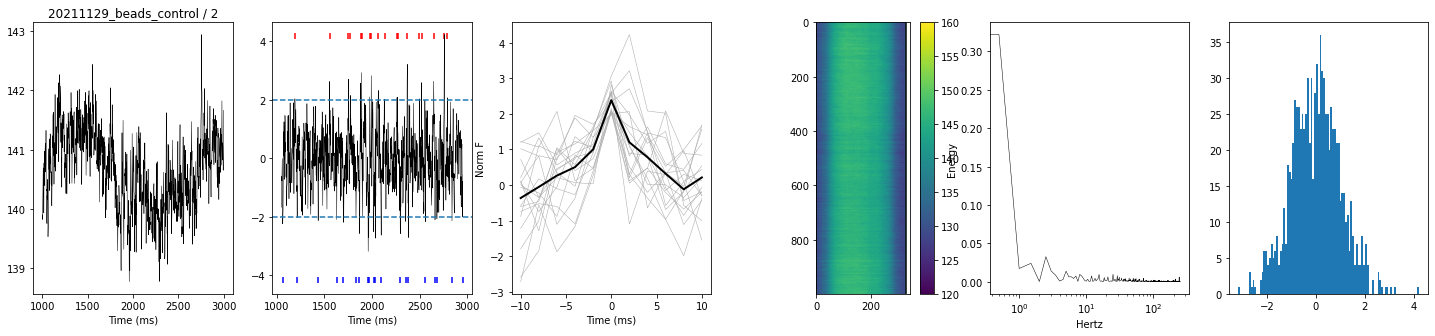

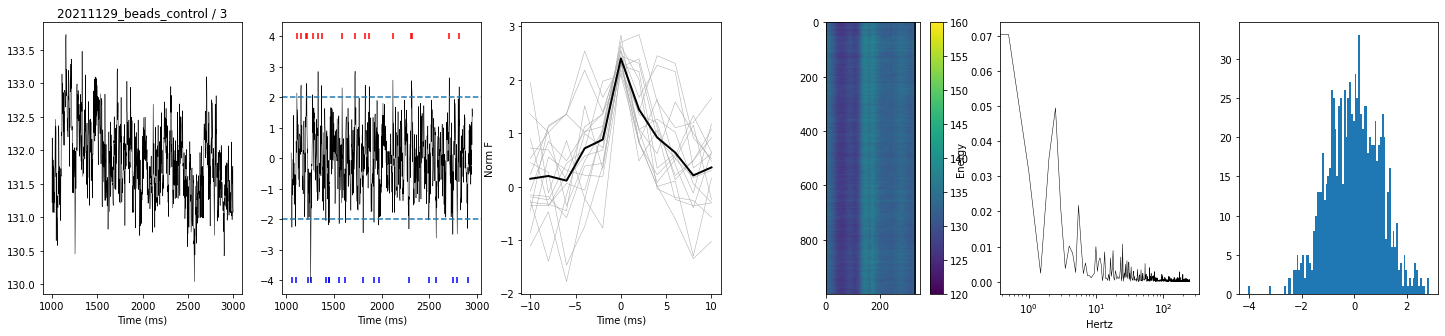

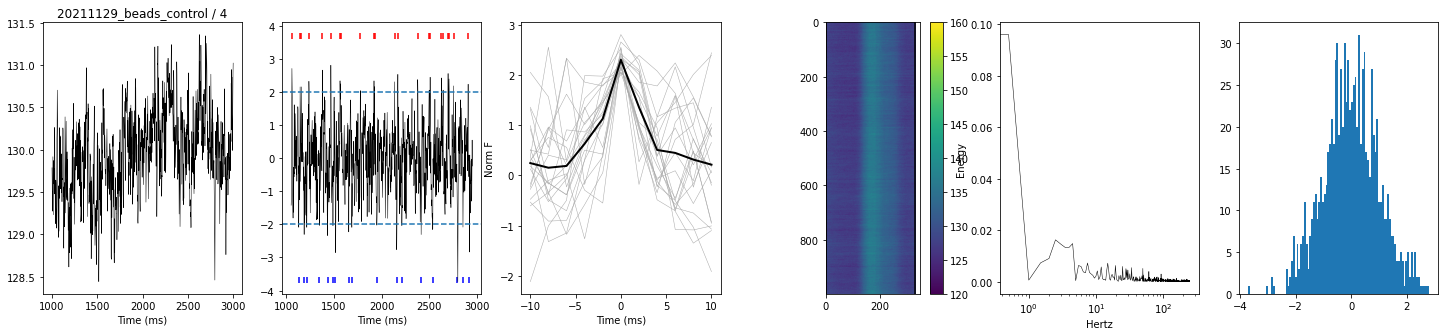

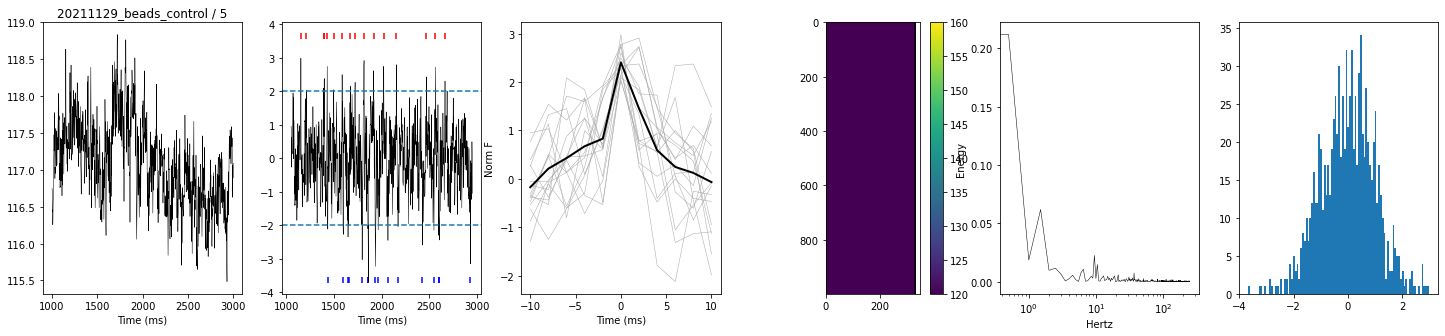

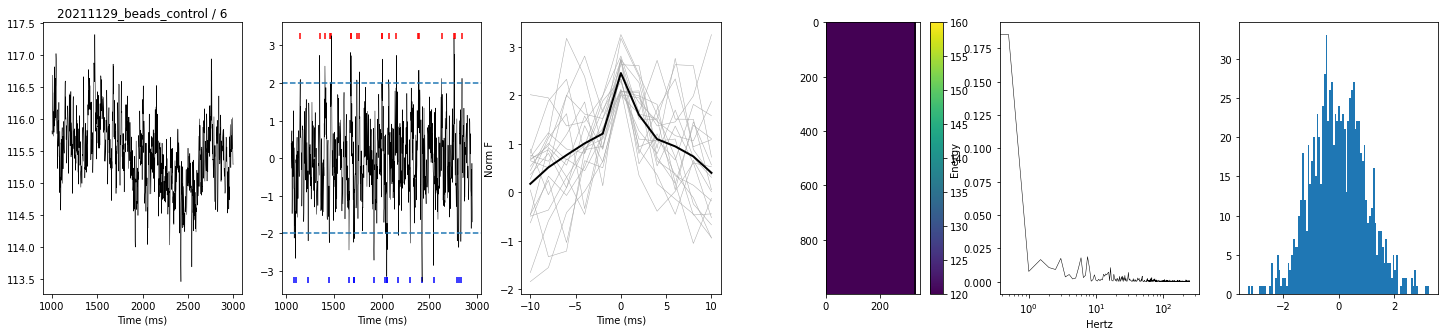

In [33]:
start_crop = 500

start_sample_global = None
end_sample_global = None

list_spike_shape = list()
list_fs = list()
nrow = 1
ncol = 6

for i,row in meta_plot.iterrows():
    
    recording_duration = row['Duration'] - row['Start_cutoff']
    cur_mat = getRecordingData(dict_data, row)

    if (start_sample_global is None):
        start_sample = 0
    else:
        start_sample = start_sample_global
    if end_sample_global is None:
        end_sample = cur_mat.shape[0]
    else:
        end_sample = end_sample_global
        
    if not pd.isna(row['Kymo_start']):
        start_sample = int(row['Kymo_start'])
    if not pd.isna(row['Kymo_end']):
        end_sample = int(row['Kymo_end'])
        
    fs = cur_mat.shape[1]/recording_duration #kHz    
    list_fs.append(fs)
    signal = np.mean(cur_mat[start_sample:end_sample,start_crop:], axis = 0)
    time_axis = np.linspace(start_crop/(fs), recording_duration, num = len(signal))
    
    #Raw signal
    plt.figure(figsize = (25,5))
    plt.subplot(nrow,ncol,1)
    plt.plot(time_axis, signal, c = 'k', linewidth = 0.5)
    plt.xlabel('Time (ms)')
    plt.title(row['File'] + ' / ' + str(row['Measure_ID']))
    
    #Z-scored signal
    plt.subplot(nrow,ncol,2)
    zscore_val = movingZscore(signal, half_window, True)
    extreme_val = 1.1*np.max(np.abs(zscore_val))
    time_axis = np.linspace((start_crop+half_window)/fs, recording_duration-half_window/fs, num = len(zscore_val))
    peaks = peakDetection(zscore_val, threshold)
    peaks_neg = peakDetection(zscore_val, threshold, invert_signal = True)
    plt.plot(time_axis, zscore_val, c = 'k', linewidth = 0.5)
    plt.scatter(time_axis[peaks], [0.9*extreme_val]*len(peaks), c = 'r', marker = '|')
    plt.scatter(time_axis[peaks_neg], [-0.9*extreme_val]*len(peaks_neg), c = 'blue', marker = '|')
    plt.xlabel('Time (ms)')
    plt.ylim(-extreme_val, extreme_val)
    plt.axhline(threshold, linestyle = '--')
    plt.axhline(-threshold, linestyle = '--')
    
    #Spike shape
    plt.subplot(nrow, ncol,3)
    if len(peaks) > 0:
        mat_STA = np.zeros(shape = (len(peaks), 2*half_window_STA + 1))
        keep_row = np.ones(len(peaks), dtype = 'bool')
        for i,p in enumerate(peaks):
            vect = zscore_val[p-half_window_STA:p+half_window_STA+1]
            if len(vect) == 2*half_window_STA + 1:
                mat_STA[i,0:len(vect)] = vect
            else:
                keep_row[i] = False
        mat_STA = mat_STA[keep_row,:]
        ts = np.linspace(-half_window_STA/fs, half_window_STA/fs, num = mat_STA.shape[1])
        plt.plot(ts,mat_STA.T, c = 'darkgray', linewidth = 0.5)
        plt.plot(ts,np.mean(mat_STA, axis = 0), c = 'black', linewidth = 2)
        plt.xlabel('Time (ms)')
        plt.ylabel('Norm F')
        list_spike_shape.append(mat_STA)
    
    #Kymograph
    plt.subplot(nrow,ncol,4)
    ax = plt.imshow(cur_mat.T[start_crop:,:], vmin = 120, vmax = 160)
    plt.colorbar(ax)
    plt.axvline(start_sample, c = 'k')
    plt.axvline(end_sample, c = 'k')
    
    #Periodogram
    plt.subplot(nrow,ncol,5)
    freq, fft = periodogram(signal, fs = fs*1e3)
    # freq, fft = welch(signals, fs = fs*1e3)
    plt.plot(freq, fft, c = 'black', linewidth = 0.5)
    plt.xscale('log')
    plt.xlabel('Hertz')
    plt.ylabel('Energy')   
    
    #Distribution of values
    plt.subplot(nrow, ncol, 6)
    plt.hist(zscore_val,100)

In [10]:
cur_mat.shape

(329, 1500)

In [ ]:
mat_all_spikes.shape

In [ ]:
cur_mat[start_sample:end_sample,:].shape

In [ ]:
cur_mat.shape

In [ ]:
mat_STA.shape